# setup

In [1]:
!nvidia-smi

Tue Nov 26 01:24:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:85:00.0 Off |                    0 |
| N/A   37C    P0             45W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install langchain langchain-huggingface bitsandbytes datasets matplotlib scikit-learn accelerate

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import getpass
import os
from datasets import load_dataset

In [4]:
api_env_key = "HUGGINGFACEHUB_API_TOKEN"
if os.environ.get(api_env_key) is None:
    os.environ[api_env_key] = getpass.getpass(
        "Enter your Hugging Face API key: "
    )

Enter your Hugging Face API key:  ········


In [5]:
# Load shared utility methods
%run SharedUtils.ipynb

In [6]:
# Load LLAMA
%run LoadYi.ipynb

2024-11-26 01:24:47.852979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 01:24:47.877314: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 01:24:47.884506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 01:24:47.903636: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 01:24:50.237046: W tensorflow/compiler/tf2

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

7
<class 'int'>


In [7]:
dataset = load_dataset("dair-ai/emotion", "split")

train_set = dataset["train"]
test_set = dataset["test"]

print(train_set[:5])
print(test_set[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}
{'text': ['im feeling rather rotten so im not very ambitious right now', 'im updating my blog because i feel shitty', 'i never make her separate from me because i don t ever want her to feel like i m ashamed with her', 'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived', 'i was feeling a little vain when i did this one'], 'label': [0, 0, 0, 1, 0]}


In [8]:
label_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}
label_values = list(label_map.values())

train_set = train_set.map(map_labels)
test_set = test_set.map(map_labels)

X_test = test_set["text"]
y_test = test_set["label_human"]

print(train_set[:5])
print(test_set[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3], 'label_human': ['sadness', 'sadness', 'anger', 'love', 'anger']}
{'text': ['im feeling rather rotten so im not very ambitious right now', 'im updating my blog because i feel shitty', 'i never make her separate from me because i don t ever want her to feel like i m ashamed with her', 'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived', 'i was feeling a little vain when i did this one'], 'label': [0, 0, 0, 1, 0], 'label_human': ['sadness', 'sadness', 'sadness', 'joy', 'sadness']}


In [9]:
def get_reasoning(label):
    reasoning_map = {
        0: "This sentence conveys a sense of loss, disappointment, or unhappiness, often associated with words or phrases indicating regret or sorrow.",
        1: "This sentence includes positive expressions of happiness, satisfaction, or excitement, often using words that suggest joy or celebration.",
        2: "This sentence expresses affection, admiration, or strong emotional connections, often reflecting bonds of love or devotion.",
        3: "This sentence contains language that conveys frustration, irritation, or hostility, often marked by aggressive or critical tones.",
        4: "This sentence reflects apprehension, worry, or a sense of threat, often using language that conveys uncertainty or fear.",
        5: "This sentence suggests surprise or astonishment, often with words or phrases that indicate unexpected outcomes or disbelief."
    }
    return reasoning_map.get(label)

In [10]:
few_shot_examples, examples_text, examples_text_cot = prepare_examples(train_set, key="text", n_per_label=1)

print(few_shot_examples)
print("---")
print(examples_text)
print("---")
print(examples_text_cot)

[{'text': 'im feel alone and i dont know how to cope', 'label': 0, 'label_human': 'sadness'}, {'text': 'i feel really angry sometimes because for the love of god havent we been through enough', 'label': 3, 'label_human': 'anger'}, {'text': 'ive been feeling a bit nostalgic ever since i went through a box of my dads old pictures for a post i did for a href http mysalvagedtreasures', 'label': 2, 'label_human': 'love'}, {'text': 'i had a hard time focusing on my life and walked around feeling dazed and confused', 'label': 5, 'label_human': 'surprise'}, {'text': 'i have just had such a crappy week that i am still feeling all agitated and like the day wasn t what i wanted', 'label': 4, 'label_human': 'fear'}, {'text': 'id probably go with none on and hope that my date admires a confident girl who feels fine without makeup', 'label': 1, 'label_human': 'joy'}]
---
Sentence: im feel alone and i dont know how to cope
Sentiment: sadness
Sentence: i feel really angry sometimes because for the lov

# Zero-Shot Prompting Preview

In [11]:
ai_msg = zero_shot("The food was absolutely amazing and delightful!")
print(ai_msg)

ai_msg = zero_shot("The experience was the worst I've ever had.")
print(ai_msg)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Your goal is to read a sentence and classify its sentiment into one of the following categories: sadness, joy, love, anger, fear, surprise.

Now classify the following sentence. The output MUST follow this format:
Sentiment: [Classification]<|im_start|>user
The food was absolutely amazing and delightful!<|im_end|>
<|im_start|>assistant
Sentiment: Joy 

I used the definition of each sentiment category to determine that the given sentence expresses positive emotions related to finding "absolutely amazing
Your goal is to read a sentence and classify its sentiment into one of the following categories: sadness, joy, love, anger, fear, surprise.

Now classify the following sentence. The output MUST follow this format:
Sentiment: [Classification]<|im_start|>user
The experience was the worst I've ever had.<|im_end|>
<|im_start|>assistant
Sentiment: [Anger] 3 14 20 5 8 7 8


# Few-Shot Prompting Preview

In [12]:
ai_msg = few_shot("The food was absolutely amazing and delightful!", examples_text)
print(ai_msg)

ai_msg = few_shot("The experience was the worst I've ever had.", examples_text)
print(ai_msg)

Your goal is to read a sentence and classify its sentiment into one of the following categories: sadness, joy, love, anger, fear, surprise.

Here are some examples:
Sentence: im feel alone and i dont know how to cope
Sentiment: sadness
Sentence: i feel really angry sometimes because for the love of god havent we been through enough
Sentiment: anger
Sentence: ive been feeling a bit nostalgic ever since i went through a box of my dads old pictures for a post i did for a href http mysalvagedtreasures
Sentiment: love
Sentence: i had a hard time focusing on my life and walked around feeling dazed and confused
Sentiment: surprise
Sentence: i have just had such a crappy week that i am still feeling all agitated and like the day wasn t what i wanted
Sentiment: fear
Sentence: id probably go with none on and hope that my date admires a confident girl who feels fine without makeup
Sentiment: joy

Now classify the following sentence. The output MUST follow this format:
Sentiment: [Classification]<

# Few-Shot with Chain-of-Thought Preview

In [13]:
ai_msg = few_shot("The food was absolutely amazing and delightful!", examples_text_cot)
print(ai_msg)

ai_msg = few_shot("The experience was the worst I've ever had.", examples_text_cot)
print(ai_msg)

Your goal is to read a sentence and classify its sentiment into one of the following categories: sadness, joy, love, anger, fear, surprise.

Here are some examples:
Sentence: im feel alone and i dont know how to cope
Reasoning: This sentence conveys a sense of loss, disappointment, or unhappiness, often associated with words or phrases indicating regret or sorrow.
Sentiment: sadness
Sentence: i feel really angry sometimes because for the love of god havent we been through enough
Reasoning: This sentence contains language that conveys frustration, irritation, or hostility, often marked by aggressive or critical tones.
Sentiment: anger
Sentence: ive been feeling a bit nostalgic ever since i went through a box of my dads old pictures for a post i did for a href http mysalvagedtreasures
Reasoning: This sentence expresses affection, admiration, or strong emotional connections, often reflecting bonds of love or devotion.
Sentiment: love
Sentence: i had a hard time focusing on my life and wal

# Zero-Shot Evaluation

In [14]:
# sampleset = test_set.select(range(100))

In [15]:
zero_shot_results = evaluate_model(X_test, y_test, zero_shot, None)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


---
Sentence: i was still feeling weepy and strung out so maggie treated me to ice cream and a movie a href http www
True: sadness
Prediction: sadness
Processed 100/2000 examples, Time: 159.246
---

---
Sentence: i feel that third situation pretty much sums up my feelings toward this title
True: joy
Prediction: surprise
Processed 200/2000 examples, Time: 320.350
---

---
Sentence: im feeling slightly irritable today
True: anger
Prediction: anger
Processed 300/2000 examples, Time: 480.776
---

---
Sentence: ive been feeling afraid a lot lately
True: fear
Prediction: fear
Processed 400/2000 examples, Time: 635.801
---

---
Sentence: i will admit and it left me feeling shaken and a bit of a goose
True: fear
Prediction: fear
Processed 500/2000 examples, Time: 792.065
---

---
Sentence: i feel myself falling into the pit of buying it from her i think he s for real i m just skeptical of the women
True: fear
Prediction: surprise
Processed 600/2000 examples, Time: 947.962
---

---
Sentence: i 

Filtered 43 invalid predictions.
Accuracy: 44.5580
              precision    recall  f1-score   support

     sadness       0.63      0.43      0.51       573
         joy       0.66      0.53      0.59       678
        love       0.28      0.20      0.23       157
       anger       0.53      0.37      0.44       264
        fear       0.33      0.46      0.39       221
    surprise       0.09      0.56      0.15        64

    accuracy                           0.45      1957
   macro avg       0.42      0.42      0.38      1957
weighted avg       0.55      0.45      0.48      1957



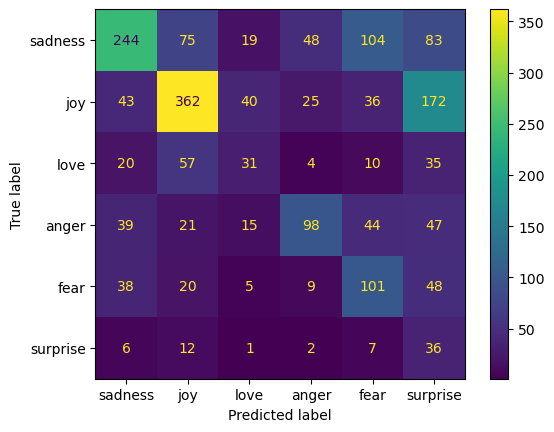

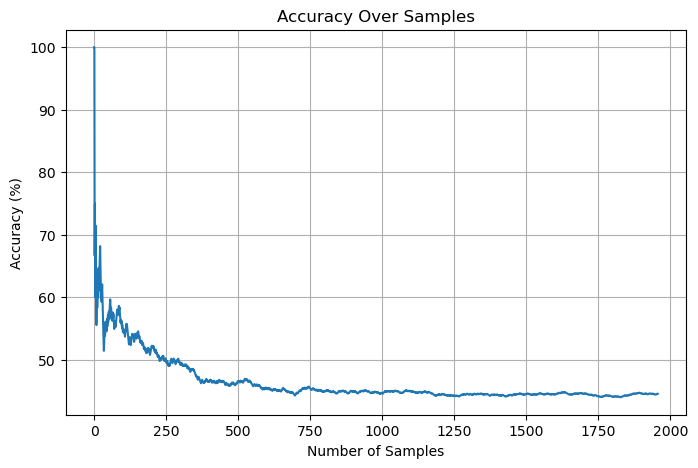

In [16]:
create_reports(y_test, zero_shot_results)

# Few-Shot Evaluation

In [17]:
few_shot_results = evaluate_model(X_test, y_test, few_shot, examples_text)

---
Sentence: i was still feeling weepy and strung out so maggie treated me to ice cream and a movie a href http www
True: sadness
Prediction: sadness
Processed 100/2000 examples, Time: 145.952
---

---
Sentence: i feel that third situation pretty much sums up my feelings toward this title
True: joy
Prediction: joy
Processed 200/2000 examples, Time: 290.979
---

---
Sentence: im feeling slightly irritable today
True: anger
Prediction: fear
Processed 300/2000 examples, Time: 437.301
---

---
Sentence: ive been feeling afraid a lot lately
True: fear
Prediction: fear
Processed 400/2000 examples, Time: 582.703
---

---
Sentence: i will admit and it left me feeling shaken and a bit of a goose
True: fear
Prediction: fear
Processed 500/2000 examples, Time: 728.943
---

---
Sentence: i feel myself falling into the pit of buying it from her i think he s for real i m just skeptical of the women
True: fear
Prediction: fear
Processed 600/2000 examples, Time: 874.217
---

---
Sentence: i have to gi

Filtered 88 invalid predictions.
Accuracy: 52.3536
              precision    recall  f1-score   support

     sadness       0.67      0.47      0.55       553
         joy       0.65      0.70      0.67       663
        love       0.34      0.27      0.30       151
       anger       0.71      0.27      0.39       262
        fear       0.29      0.68      0.41       219
    surprise       0.24      0.31      0.27        64

    accuracy                           0.52      1912
   macro avg       0.48      0.45      0.43      1912
weighted avg       0.58      0.52      0.53      1912



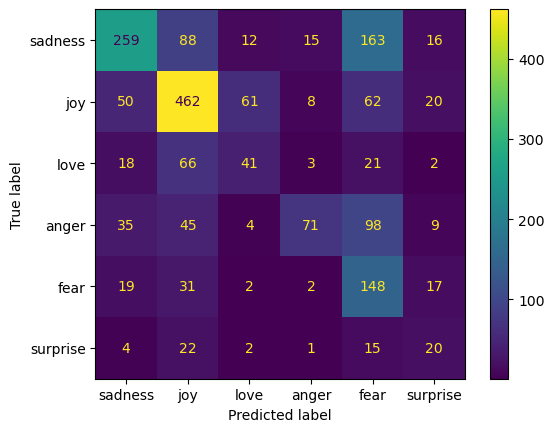

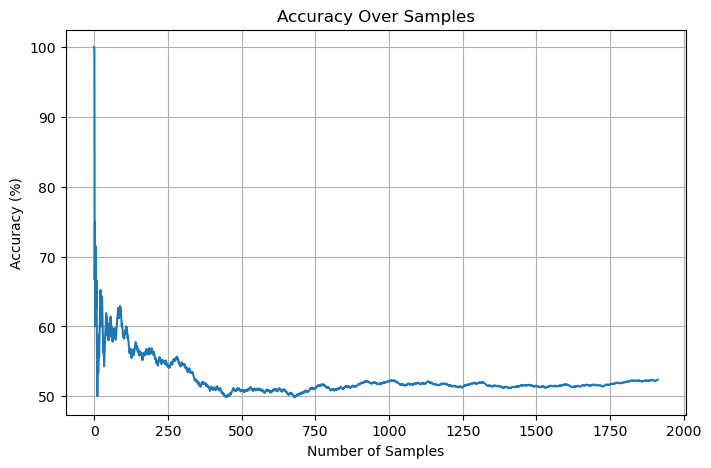

In [18]:
create_reports(y_test, few_shot_results)

# Few-Shot Chain-of-Thought Evaluation

In [19]:
few_shot_cot_results = evaluate_model(X_test, y_test, few_shot, examples_text_cot)

---
Sentence: i was still feeling weepy and strung out so maggie treated me to ice cream and a movie a href http www
True: sadness
Prediction: sadness
Processed 100/2000 examples, Time: 163.868
---

---
Sentence: i feel that third situation pretty much sums up my feelings toward this title
True: joy
Prediction: joy
Processed 200/2000 examples, Time: 327.667
---

---
Sentence: im feeling slightly irritable today
True: anger
Prediction: anger
Processed 300/2000 examples, Time: 491.334
---

---
Sentence: ive been feeling afraid a lot lately
True: fear
Prediction: fear
Processed 400/2000 examples, Time: 655.331
---

---
Sentence: i will admit and it left me feeling shaken and a bit of a goose
True: fear
Prediction: fear
Processed 500/2000 examples, Time: 818.934
---

---
Sentence: i feel myself falling into the pit of buying it from her i think he s for real i m just skeptical of the women
True: fear
Prediction: surprise
Processed 600/2000 examples, Time: 983.242
---

---
Sentence: i have 

Filtered 114 invalid predictions.
Accuracy: 55.0901
              precision    recall  f1-score   support

     sadness       0.64      0.61      0.62       553
         joy       0.66      0.69      0.68       662
        love       0.34      0.21      0.26       149
       anger       0.66      0.29      0.41       251
        fear       0.36      0.54      0.43       210
    surprise       0.17      0.38      0.23        61

    accuracy                           0.55      1886
   macro avg       0.47      0.45      0.44      1886
weighted avg       0.58      0.55      0.55      1886



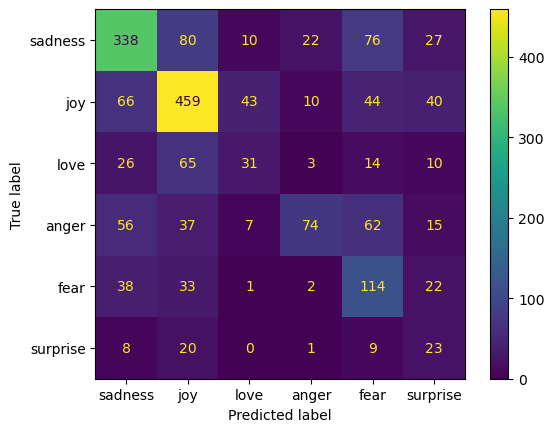

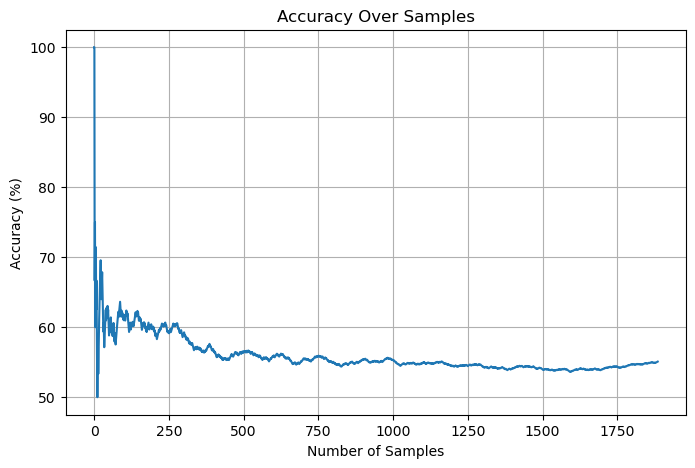

In [20]:
create_reports(y_test, few_shot_cot_results)